# Home Value Analysis
</span>

## The Question / Problem

You have been engaged as an independent auditor by the Denver County Assessor's Office to assist with some crucial analyses.

### Annual Report Insights

The Assessor's Office is preparing to release their annual report on the valuation of residential single-family properties. They have asked you to thoroughly examine the data and identify at least two key findings that can be highlighted in their annual report to the public.

In [1]:
# Import Pandas, Matplotlib, and Seaborn and allow for inline plotting

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import zscore

%matplotlib inline

# import matplotlib as mpl # for non-interactive, pure object-oriented plotting
from matplotlib import pyplot as plt
import matplotlib.style as style
# plt.style.use('ggplot')

# Set to None to display all columns
pd.set_option('display.max_columns', None) 

In [3]:
# Load Buildings
buildings = pd.read_csv("/buildings.csv")

# Check columns for data types and identify any missing values 
#buildings.info()

# Check columns for missing values 
#buildings.isnull().sum().sort_values(ascending=False)

# Columns with missing values 
# Stories 41954 | UnitCount 41939 | ExtWallDscrSec 30821 | ExtWallSec 30821 | AcDscr 23650 | Ac 23573 | Roof_CoverDscr 19528
# Roof_Cover 19525 | HeatingDscr 1134 | Heating 1097 | IntWallDscr 216 | IntWall 215 | ConstCodeDscr 179
# ExtWallDscrPrim 29 | ExtWallPrim 7

# Drop NA rows and verify 
buildings.dropna(subset=['ExtWallDscrPrim'], inplace=True)

# I am dropping the following columns for the reasons after the description
# Stories - this field is only used for commercial properties
# UnitCount - the number of residential units in the building specified. This is mostly used with apartments I am dropping this
#   because they also state "we generally do not have apartment unit numbers delineated in our databse since they are all on 
#   one account"
# ExtWallSec, ExtWallDscrSec - code and description of the secondary material used on the exterior walls of the structure 
# Ac, AcDscr - we have a lot of null values and this column is for if an air conditioner exists
# Roof_CoverDscr, Roof_Cover Dropping to to the number of null values
# Heating, HeatingDscr - we have null values and this column is for if a heater exists
# IntWallDscr, IntWall - describes the primary material used for the interior walls of the structure - I don't believe this info is 
#   not crucial to my analysis
# ConstCodeDscr - Description of the construction code assoc with bldg/section
# ConstCode - identifies what the main type of construction material for the bldg
# ExtWallPrim - I don't believe this info is not crucial to my analysis
# status_cd - whether the account is currently active “A” or has been deactivated “D”. - The data set only includes active accounts) 
# CompCode - The Building’s % complete for the current year I don't believe this info is not crucial to my analysis
# section_num - Building section number - particularly for commercial properties, I don't believe this info is not crucial to my analysis

# dropping anything related to codes as long as we have the description - designCode, qualityCode, bldgClass, bsmtType, carStorageType


# Drop Columns Formatted for readability
columns_to_drop = [
    'ConstCodeDscr', 'section_num', 'carStorageType',
    'bldgClass', 'CompCode', 'qualityCode', 'status_cd', 'ConstCode',
    'Heating', 'HeatingDscr', 'Ac', 'AcDscr', 'Stories', 'UnitCount',
    'ExtWallSec', 'ExtWallDscrSec', 'Roof_CoverDscr', 'Roof_Cover',
    'IntWallDscr', 'IntWall', 'ExtWallPrim', 'designCode'
]
# Drop Columns
buildings.drop(columns_to_drop, axis=1, inplace=True)


# Convert basement type to either unfinished (0) or finished(1)
buildings['bsmtCond'] = buildings['bsmtTypeDscr'].apply(lambda x: 1 if 'FINISHED' in x else 0)

# Create a new column calculating the age of the home based on builtYear
buildings['age'] = 2021 - buildings['builtYear']

# Rename the column designCodeDscr to 'homeDesign' to better describe our column
buildings.rename(columns={'designCodeDscr': 'homeDesign'}, inplace=True)

# Rename the column TotalFinishedSF to 'livingSpaceSqft' to better describe our column
buildings.rename(columns={'TotalFinishedSF': 'livingSpaceSqft'}, inplace=True)



In [68]:
# Load Land
land = pd.read_csv('/land.csv')

# Check columns for data types and identify any missing values 
#land.isnull().sum()
# landClass 1 and landClassDscr 1 - we will drop these rows since they are one apiece

# Drop NA rows and verified 
land.dropna(subset=['landClass', 'landClassDscr', 'landUnitValue'], inplace=True)

# I am dropping the following columns for the reasons after the description
# status_cd - whether the account is currently active “A” or has been deactivated “D”. - The data set only includes active accounts) 
# GIS_acreage, GIS_sqft - this is not survey quality sqft measurements 
# landClass - classification code, we have the description column as well

land.drop(['status_cd', 'GIS_acreage', 'GIS_sqft', 'landClass'], axis=1, inplace=True)


In [67]:
# Load Owner Info
owner_address = pd.read_csv('/owner_address.csv')

# Check columns for data types and identify any missing values 
#owner_address.info()
# owner_address.isnull().sum()
# str_pfx 37950
# str_sfx 616

# I am dropping the following columns for the reasons after the description
# str_pfx - Instead of imputing default values I am going to drop this, the missing values are spread across significantly
 # and I don't believe this info is not crucial to my analysis
# str_sfx - I don't believe this info is not crucial to my analysis
# sub_code subdivision code, we have the description column as well
owner_address.drop(['str_pfx', 'str_sfx', 'sub_code'], axis=1, inplace=True)


In [66]:
# Load Values Info
values = pd.read_csv('/values.csv')
values

# Check columns for data types and identify any missing values 
# values.info()
# values.isnull().sum()


# I am dropping the following columns for the reasons after the description
# xfAssessedVal - Assessed value for extra features associated with the account - all of the values are missing
# status_cd - whether the account is currently active “A” or has been deactivated “D”. - The data set only includes active accounts) 
# xfActualVal - value attributed to extra features, generally on commercial properties

# bldAssessedVal column will not help this analysis but I am leaving 

values.drop(['xfAssessedVal', 'status_cd', 'xfActualVal'], axis=1, inplace=True)


In [7]:
values.isnull().sum()


strap                0
tax_yr               0
bldAcutalVal         0
LandAcutalVal        0
totalActualVal       0
landAssessedVal      0
bldAssessedVal      24
totalAssessedVal     0
dtype: int64

In [8]:
# Merge buildings with land using 'strap' as the common key

buildings_land = pd.merge(buildings, land, on='strap', how='left')

# Merge buildings_land with owner_address
buildings_land_owner = pd.merge(buildings_land, owner_address, on='strap', how='left')

# Merge buildings_land_owner with value
buildings_land_owner_value = pd.merge(buildings_land_owner, values, on='strap', how='left')


In [9]:
buildings_land_owner_value.shape

# buildings (41932, 20)
# land (41960, 4)
# owner_address(41961, 10)
# values(41961, 8)
# buildings_land_owner_value.shape(41932, 41)

# We maintained our row counts for building and our column count increased 

(41932, 41)

In [10]:
#  Check and count the number of missing (null or NaN) values in each column of the DataFrame

buildings_land_owner_value.isnull().sum().sort_values(ascending=False)

# I dropped these previously but will drop again 
buildings_land_owner_value.drop(['landUnitValue', 'landUnitType', 'landClassDscr'], axis=1, inplace=True)

In [11]:
# Descriptive statistics for numerical columns
buildings_land_owner_value.describe()

,bld_num,builtYear,EffectiveYear,bsmtSF,carStorageSF,nbrBedRoom,nbrRoomsNobath,mainfloorSF,nbrThreeQtrBaths,nbrFullBaths,nbrHalfBaths,livingSpaceSqft,bsmtCond,age,str_num,section,range,nh,mill_levy,tax_yr,bldAcutalVal,LandAcutalVal,totalActualVal,landAssessedVal,bldAssessedVal,totalAssessedVal
count,41932.000000,41932.000000,41932.000000,41932.000000,41932.000000,41932.000000,41932.000000,41932.000000,41932.000000,41932.000000,41932.000000,41932.000000,41932.000000,41932.000000,41932.000000,41932.000000,41932.000000,41932.000000,41932.000000,41932.0,4.193200e+04,4.193200e+04,4.193200e+04,41932.000000,41909.000000,41932.000000
mean,1.001049,1977.195149,1987.054612,696.512902,444.909926,3.213417,6.970571,1314.407588,0.455356,1.585877,0.459661,1862.093986,0.649957,43.804851,2168.197844,19.827101,69.690737,512.547744,95.561060,2021.0,4.062733e+05,2.772128e+05,6.834862e+05,19833.828007,29065.877544,48883.762711
std,0.032377,27.965244,20.641085,634.201216,253.740562,0.938945,2.089069,523.618135,0.629337,0.757681,0.524938,807.887165,0.476989,27.965244,3155.837013,11.087633,1.012331,10245.698137,12.456094,0.0,2.743685e+05,2.779534e+05,4.375809e+05,19901.569820,19611.783433,31292.942565
min,1.000000,1860.000000,1871.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,69.000000,101.000000,57.697000,2021.0,0.000000e+00,0.000000e+00,2.710000e+04,0.000000,0.000000,2352.000000
25%,1.000000,1963.000000,1976.000000,0.000000,312.000000,3.000000,6.000000,978.000000,0.000000,1.000000,0.000000,1254.000000,0.000000,23.000000,619.000000,10.000000,69.000000,162.000000,87.045000,2021.0,2.496000e+05,1.025000e+05,4.221000e+05,7336.000000,17854.000000,30180.000000
50%,1.000000,1981.000000,1991.000000,728.000000,448.000000,3.000000,7.000000,1215.000000,0.000000,1.000000,0.000000,1742.000000,1.000000,40.000000,1295.000000,20.000000,69.000000,240.000000,95.984000,2021.0,3.553000e+05,1.639000e+05,5.775450e+05,11733.000000,25418.000000,41298.000000
75%,1.000000,1998.000000,2000.000000,1134.000000,592.000000,4.000000,8.000000,1561.000000,1.000000,2.000000,1.000000,2314.000000,1.000000,58.000000,2445.000000,30.000000,70.000000,440.000000,97.139000,2021.0,4.821250e+05,3.675000e+05,8.051000e+05,26299.750000,34477.000000,57565.000000
max,2.000000,2021.000000,2021.000000,4743.000000,4800.000000,10.000000,90.000000,9522.000000,7.000000,7.000000,4.000000,19044.000000,1.000000,161.000000,52423.000000,36.000000,74.000000,990901.000000,172.492000,2021.0,4.927820e+06,5.145400e+06,7.872360e+06,367896.000000,352339.000000,562874.000000


### Descriptive statistics overview
The dataset comprises information on 41,932 buildings with construction years from 1860 to 2021. The total living space in sqft exhibits a broad range, from a minimum of 0 to a maximum of 19044 square feet, with a mean of 1862.25. We will need to investigate this further. 

In [12]:
buildings_land_owner_value[buildings_land_owner_value['livingSpaceSqft'] <5]

,strap,bld_num,homeDesign,qualityCodeDscr,bldgClassDscr,builtYear,EffectiveYear,bsmtSF,bsmtType,bsmtTypeDscr,carStorageSF,carStorageTypeDscr,nbrBedRoom,nbrRoomsNobath,mainfloorSF,nbrThreeQtrBaths,nbrFullBaths,nbrHalfBaths,livingSpaceSqft,ExtWallDscrPrim,bsmtCond,age,str_num,str,city,sub_dscr,section,township,range,nh,mill_levy,tax_yr,bldAcutalVal,LandAcutalVal,totalActualVal,landAssessedVal,bldAssessedVal,totalAssessedVal
173,R0000448,1,2-3 Story,VERY GOOD +,SINGLE FAM RES IMPROVEMENTS,2021,2021,0,0,0,0,0,6.0,12.0,1,4.0,1.0,1.0,1,Frame Wood/Shake,0,0,835.0,8TH,BOULDER,CHAUTAUQUA HEIGHTS - BO,36.0,1N,71.0,103.0,87.045,2021,3980,358200,362180,25611.0,285.0,25896
6656,R0020955,2,1 Story - Ranch,AVERAGE,SINGLE FAM RES IMPROVEMENTS,1971,1971,0,0,0,1065,DETACHED GARAGE,0.0,0.0,0,0.0,0.0,0.0,0,Frame Wood/Shake,0,50,404.0,ELIZABETH,LAFAYETTE,CANNON HEIGHTS - LA,2.0,1S,69.0,460.0,91.394,2021,108360,105840,214200,7568.0,7748.0,15316
9004,R0029599,2,1 Story - Ranch,AVERAGE,SINGLE FAM RES IMPROVEMENTS,1987,1987,0,0,0,720,DETACHED GARAGE,0.0,1.0,0,0.0,0.0,0.0,0,Brick Veneer,0,34,2885.0,MAYA,UNINCORPORATED,PALO PARK 1 REFILE - BOV,17.0,1N,70.0,124.0,90.811,2021,471900,398000,869900,28457.0,33741.0,62198
41922,R0612986,1,2-3 Story,GOOD +,SINGLE FAM RES IMPROVEMENTS,2020,2020,0,0,0,0,0,0.0,0.0,1,0.0,0.0,0.0,1,Frame Wood/Shake,0,1,2150.0,TAMARACK,BOULDER,ROWAN NICO MINOR SUB FINAL,18.0,1N,70.0,122.0,87.045,2021,2261,203490,205751,14550.0,162.0,14712


In [13]:
# We filtered our results to < 5
# buildings_land_owner_value[buildings_land_owner_value['livingSpaceSqft'] <5]

# we also looked <100 and Zillow confirmed sqft
# we also spot checked a few more < 500 and all were confirmed on zillow



# We have 2 rows with null values and 2 rows with 1 for livingSpaceSqft. looking at some of the rows for livingSpaceSqft 
# confirmed sqft on zillow
buildings_land_owner_value.loc[173, 'livingSpaceSqft'] = 3236
buildings_land_owner_value.loc[6656, 'livingSpaceSqft'] = 924
buildings_land_owner_value.loc[9004, 'livingSpaceSqft'] = 1246
buildings_land_owner_value.loc[41922, 'livingSpaceSqft'] = 6332

Text(0.5, 1.0, 'Distribution of Total Assessed Property Values')

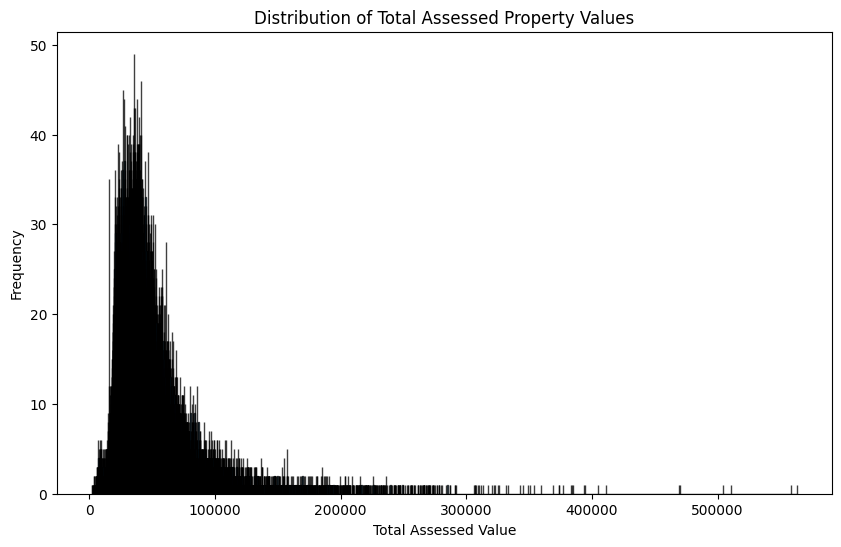

In [14]:
# Key Finding 1: Distribution of Assessed Property Values

# Column we want to create a histogram
assessed_values = buildings_land_owner_value['totalAssessedVal']

# Plot the histogram
figure, axes= plt.subplots(figsize=(10, 6))
axes.hist(assessed_values, bins=assessed_values.nunique(), edgecolor='black', alpha=0.75)
axes.set_xlabel('Total Assessed Value')
axes.set_ylabel('Frequency')
axes.set_title('Distribution of Total Assessed Property Values')

In [15]:
# Look at the underlying data
data = buildings_land_owner_value['totalAssessedVal'].dropna()

# Display basic statistics of the data
data_description = data.describe()

data_description


count     41932.000000
mean      48883.762711
std       31292.942565
min        2352.000000
25%       30180.000000
50%       41298.000000
75%       57565.000000
max      562874.000000
Name: totalAssessedVal, dtype: float64

### Key Finding 1: Distribution of Assessed Property Values

Our initial analysis focused on the Total Assessed Property Values, uncovering valuable insights through graphical representation and descriptive statistics. The mean total assessed property value stands at approximately 48,884, highlighting the average value in our dataset. The associated standard deviation of 31,293 signifies considerable variability, underscoring the diverse range of assessed property values. Examining the extremes, we observe a minimum value of 2,352, indicating the presence of lower-valued properties. In contrast, the dataset's maximum assessed value reaches 562,874, suggesting the inclusion of high-valued properties. 

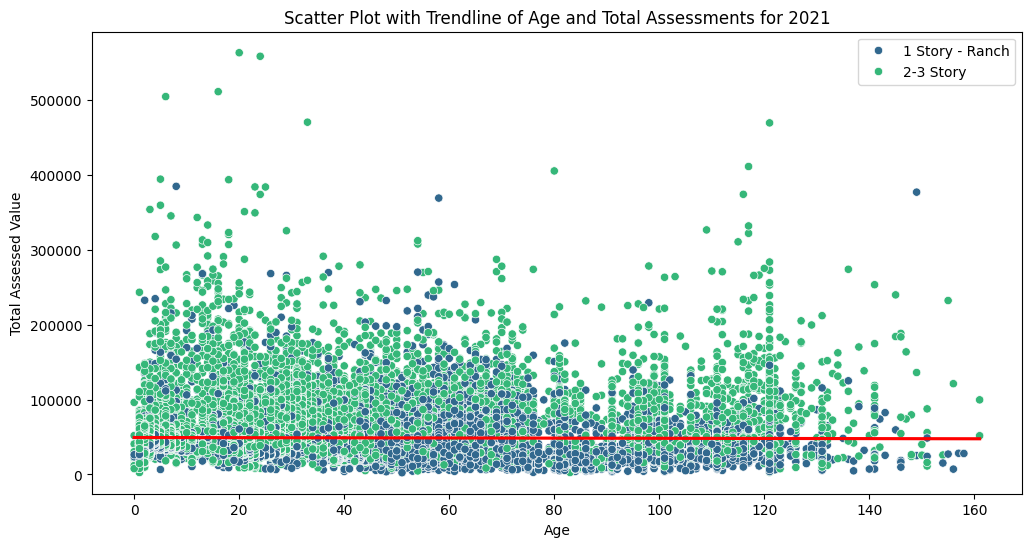

In [16]:
# Scatter Plot with Trendlines
fig, ax = plt.subplots(figsize=(12, 6))


# Scatter Plot
sns.scatterplot(x='age', y='totalAssessedVal', hue='homeDesign', data=buildings_land_owner_value, palette='viridis', ax=ax)

# Add Trendline
sns.regplot(x='age', y='totalAssessedVal', data=buildings_land_owner_value, scatter=False, ax=ax, color='red', line_kws={'label': 'Trendline for Built Year'})

ax.set_xlabel('Age')
ax.set_ylabel('Total Assessed Value')
ax.set_title('Scatter Plot with Trendline of Age and Total Assessments for 2021')
ax.legend()

#### Looking at a secondary plot
Looking at our graph it appears that we have a very weak linear relationship between the two variables. We calculated the correlation coefficient at -0.0094; this small magnitude suggests that there is little to no linear relationship between the age of the properties and their total assessed values. We should note that a low correlation coefficient does not necessarily mean there is no relationship; it simply means that a linear model does not well capture any relationship. 

Text(0.5, 1.0, 'Township-wise Distribution of Property Assessments')

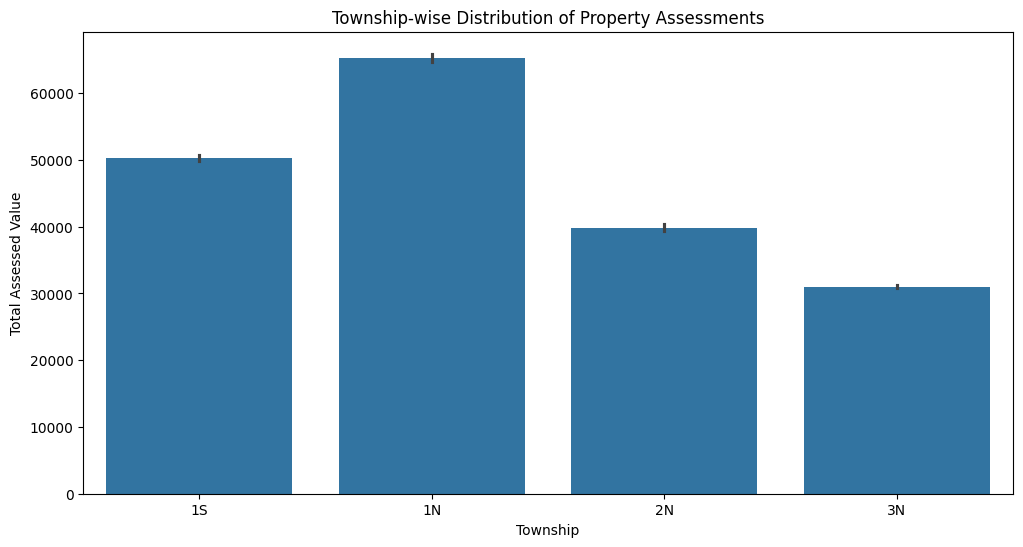

In [17]:
# Key Finding 2: Township-wise Distribution of Property Assessments

# Create a bar chart to visualize the distribution of property assessments for each township
figure, axes = plt.subplots(figsize=(12, 6))
sns.barplot(x='township', y='totalAssessedVal', data=buildings_land_owner_value)
axes.set_xlabel('Township')
axes.set_ylabel('Total Assessed Value')
axes.set_title('Township-wise Distribution of Property Assessments')

### Key Finding 2: Township-wise Distribution of Property Assessments

Our second key finding was uncovered when we explored the distribution of property assessments across different townships within Denver County. The bar chart illustrates each township's average total assessed values, providing helpful insights into the economic landscape of residential properties. Notably, Township 1N emerges with the highest average total assessed value at approximately 65,266, followed by Township 1S with an average of 50,337: township 2N and 3N exhibit slightly lower average values at approximately 39,872 and 31,034, respectively. 

### Estimate Home Values

The Assessors Office needs help improving their valuation process for residential single family properties.  They have asked you to write a KNN alogorithm to value new homes based on similar home sales.  By law, residential properties must be valued by using a "market approach". This predicts the price a property would bring on the open market in a transaction between a willing, informed, and knowledgeable buyer and seller.  A property can be valued through the process of analyzing comparable sales.  A comparable sale is any qualified sale in the last 5 years (January 2015 - December 2020).

The central factors used by the Assessors for property valuation are:

- Location
- Living Area (SQFT)
- Age of the Home
- Finished Basement

In [18]:
# Load Sales Info not sure if I need it for the KNN
sales = pd.read_csv('/Users/cristianthirteen/Downloads/Notre Dame/Python FA23/final project/sales.csv')


# Convert 'tdate' to datetime format
sales['date_of_sale'] = pd.to_datetime(sales['Tdate'])

# Filter the data to the specified timeframe
sales = sales[(sales['date_of_sale'] >= '2015-01-01') & (sales['date_of_sale'] <= '2020-12-31')]


sales.info()

/var/folders/16/wq4_bln96mqg5s2nfgwdsgp40000gn/T/ipykernel_8392/1959366679.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sales['date_of_sale'] = pd.to_datetime(sales['Tdate'])


<class 'pandas.core.frame.DataFrame'>
Index: 31624 entries, 21 to 221134
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   strap         31624 non-null  object        
 1   deedNum       31624 non-null  object        
 2   Tdate         31624 non-null  object        
 3   sales_cd      31624 non-null  object        
 4   deed_type     31624 non-null  object        
 5   price         31601 non-null  float64       
 6   status_cd     31624 non-null  object        
 7   date_of_sale  31624 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 2.2+ MB


In [19]:
# Simplified KNN?

# Merge the datasets on 'strap' to combine building information with sale dates
merged_data = pd.merge(buildings_land_owner_value, sales, on='strap', how='inner')

def knn_2d_specific_x(merged_data, k, nh, builtYear, livingSpaceSqft, bsmtCond, visualize=False):
    
    """
    To demonstrate how the KNN algorithm produces a prediction in a 2D case
    
    Input:
    
        df - DataFrame with x, y columns
        k  - number of neighbors to consider
        x_pt - value of x where we want to make prediction
    
    Output:
        Prediction 
    """
        
    df_temp = merged_data.copy()
    df_temp['distance'] = np.sqrt(
        (df_temp.nh - nh)**2 +
        (df_temp.builtYear - builtYear)**2 +
        (df_temp.livingSpaceSqft - livingSpaceSqft)**2 +
        (df_temp.bsmtCond - bsmtCond)**2
    )
    y_pred = df_temp.loc[df_temp.distance.nsmallest(k).index].price.mean()
    df_knn = df_temp.loc[df_temp.distance.nsmallest(k).index]

        
    return y_pred

    

In [20]:
# Test the function
knn_2d_specific_x(merged_data, k=3, nh=120, builtYear=2000, livingSpaceSqft=2500, bsmtCond=1, visualize=True)

627333.3333333334

In [21]:
# Get unique values to use in the KNN Test Function

# Display unique values for 'nh'
unique_values_nh = buildings_land_owner_value['nh'].unique().tolist()
print("Unique values for column 'nh':")
print(unique_values_nh)

Unique values for column 'nh':
[160.0, 115.0, 102.0, 170.0, 120.0, 109.0, 105.0, 103.0, 101.0, 162.0, 166.0, 174.0, 107.0, 126.0, 140.0, 122.0, 158.0, 148.0, 164.0, 142.0, 146.0, 150.0, 401.0, 405.0, 430.0, 410.0, 460.0, 465.0, 472.0, 820.0, 480.0, 940.0, 178.0, 901.0, 910.0, 903.0, 930.0, 172.0, 920.0, 911.0, 157.0, 830.0, 124.0, 145.0, 152.0, 154.0, 159.0, 420.0, 155.0, 415.0, 450.0, 440.0, 132.0, 144.0, 490820.0, 425.0, 156.0, 129.0, 451.0, 136.0, 133.0, 130.0, 201.0, 203.0, 202.0, 204.0, 256.0, 255.0, 205.0, 223.0, 240.0, 241.0, 962.0, 257.0, 960.0, 825.0, 501.0, 242.0, 243.0, 137.0, 134.0, 470.0, 135.0, 128.0, 455.0, 445.0, 187101.0, 293201.0, 291201.0, 293204.0, 298201.0, 298204.0, 495405.0, 990901.0, 495401.0]


### Ethics Review
Fairness and accuracy are vitally important.  If the assessed values are too high, the property owners will overpay in taxes.  If the assessed values are too low then we may fall short of the capital needed to cover the budget approved by legislators.  As such, thinking through the impact of how we predict home prices is vitial.

**Answer**

Building and deploying a predictive model such as KNN demands a delicate balance between various factors to ensure ethical considerations and model performance. Striving for transparency and accountability throughout the model-building process is crucial. Regularly reviewing and updating the model and documenting features, methodology, and assumptions establish a foundation for ethical use. 

It is also essential to consider potential pitfalls of KNN, like bias arising from skewed or unrepresentative training data, the risk of overfitting or underfitting based on the choice of K, the impact of irrelevant features on predictions, and the consequences of missing or incorrect data. Ensuring fairness involves using a representative and unbiased dataset, selecting an appropriate K, and considering only relevant features. As data scientists, we should also have transparency about the model's limitations and perform regular audits, which can help maintain fairness. 

## EDA for the Annual Report Insights

### Goal
Perform EDA on the property valuations for "1-Story" and "2-3 Story" single family residential buildings.  Identify at least 2 key insights and/or graphs that tell a story about the valuations for these properties for the annual report.

### Explore the Data

Tasks:
- Explore the relationships in the data (univariate, bivariate, etc)
- Explore outliers
- Provide a summary of your findings.
    - Highlight at least 2 key findings and/or graphs that you feel would be interesting to share in the Annual Report to Homeowners.

In [31]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# qualified_sales_5yrs['price']
# print(qualified_sales_5yrs['price'].dtype)
qualified_sales_5yrs[['livingSpaceSqft', 'price']].describe()

,livingSpaceSqft,price
count,11751.00,11751.00
mean,1979.18,602946.30
std,811.19,375476.52
min,150.00,29000.00
25%,1364.50,395000.00
50%,1891.00,522000.00
75%,2473.00,687000.00
max,10188.00,5779000.00


Text(0.5, 1.0, 'Distribution of Living Space Sqft')

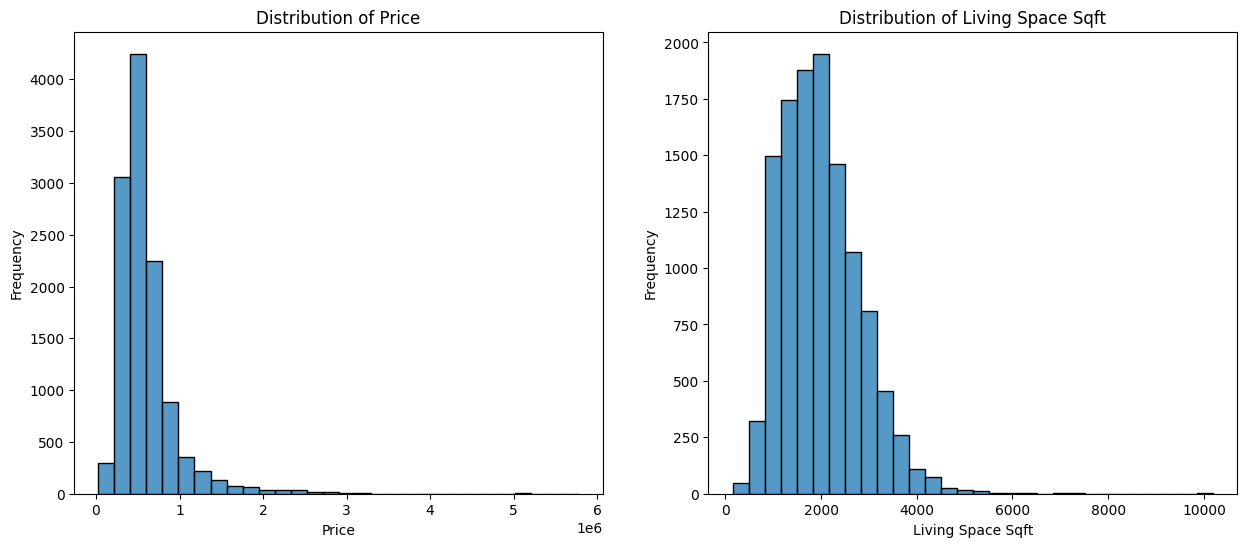

In [35]:
# Set up grid
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot histogram for 'price'
sns.histplot(data=qualified_sales_5yrs, x='price', bins=30, ax=axes[0])
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Price')

# Plot histogram for 'livingSpaceSqft'
sns.histplot(data=qualified_sales_5yrs, x='livingSpaceSqft', bins=30, ax=axes[1])
axes[1].set_xlabel('Living Space Sqft')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Living Space Sqft')

Text(0.5, 1.0, 'Scatter Plot with Regression Line: Price vs Living Space Sqft')

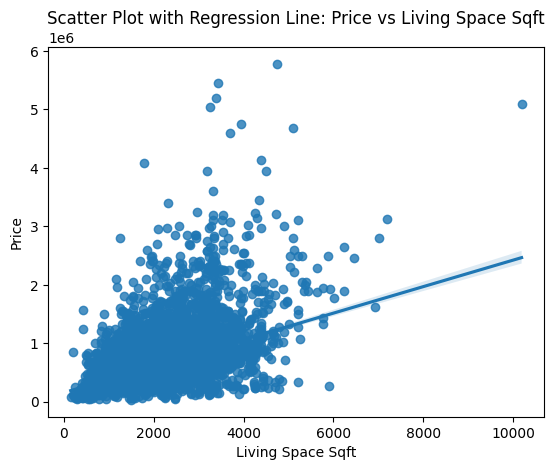

In [38]:

# Scatter plot with a regression line for 'price' versus 'livingSpaceSqft'
sns.regplot(data=qualified_sales_5yrs, x='livingSpaceSqft', y='price')
plt.xlabel('Living Space Sqft')
plt.ylabel('Price')
plt.title('Scatter Plot with Regression Line: Price vs Living Space Sqft')


### Observations

The mean living space size is approximately 1979 sqft, with a standard deviation of 811.19, indicating a notable spread in the sizes of homes.
For 'price,' the mean is 602,946.30, with a standard deviation of 375,476.52, highlighting substantial variability in home prices. The minimum and maximum values indicate a wide price range, with the smallest home priced at 29,000 and the largest at 5,779,000.

The scatter plot reinforces these observations, revealing a dense concentration of points in the 0 - 4000 sqft range for living area, suggesting considerable price variability among homes of similar sizes. A few high-value homes further emphasize the right skewness, contributing to the average price being significantly influenced.
In summary, the dataset is characterized by most homes in the lower price range. In contrast, a handful of high-value homes substantially impact the average, introducing the right skewness to the distribution. These findings underscore the importance of considering outliers in the analysis to understand the housing market better, which we see in the next graph.

<Axes: title={'center': 'price'}, xlabel='homeDesign'>

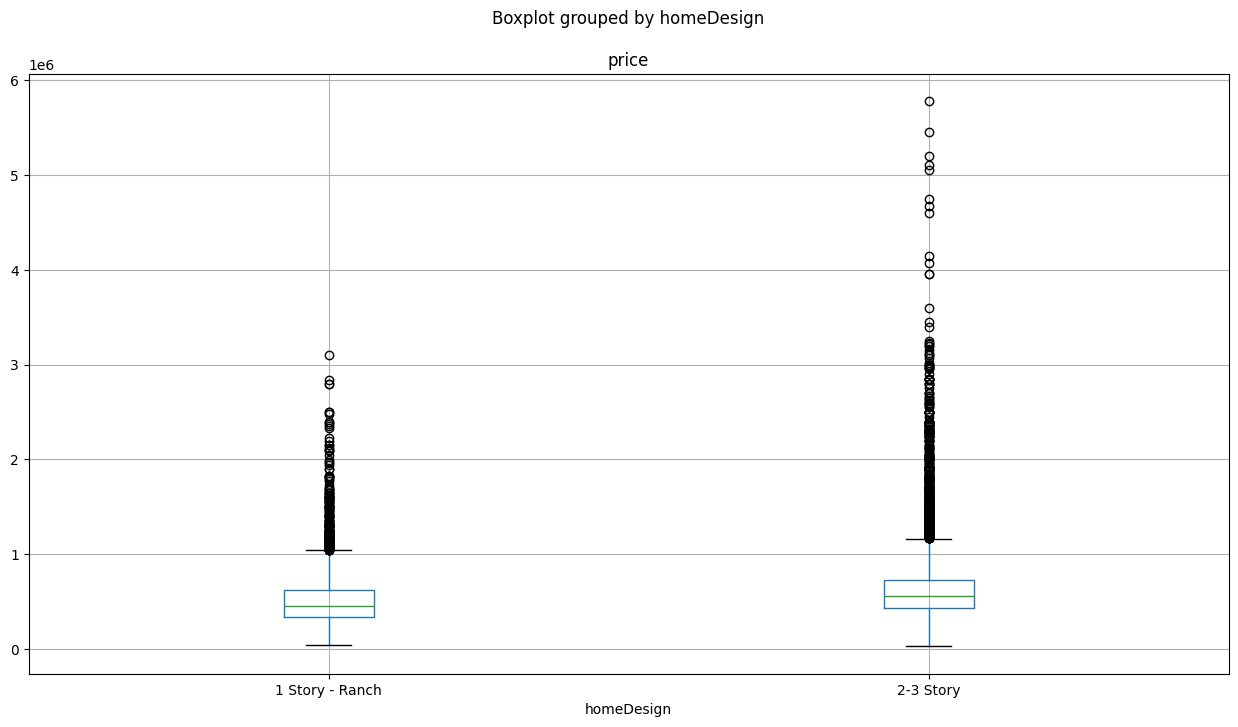

In [48]:
qualified_sales_5yrs.boxplot(column = 'price', by = 'homeDesign', figsize = (15,8))

In [ ]:
# Calculate z-scores for the 'price' column
z_scores = zscore(qualified_sales_5yrs['price'])

# Mask for identifying outliers based on z-scores
outliers_z = (z_scores > 3) | (z_scores < -3)

# Results
outliers_df_z = qualified_sales_5yrs[outliers_z]

outliers_df_z.sample(5)

# Looking at these on zillow they appear to be legit outliers

### Obervation

To investigate these outliers further, we employed z-scores as a statistical measure to identify potential anomalies within the price column. We chose this methodology because the z-score provides a standardized approach for comparing and quantifying deviations from the mean. It is independent of the scale of the data and offers clear interpretability. A z-score threshold greater than three or less than -3 was applied, following the standard convention for detecting extreme values. The identified outliers were then extracted into a new DataFrame named 'outliers_df_z,' allowing for targeted examination and analysis. A random sample of five rows from this DataFrame was selected to offer a brief snapshot for closer inspection. During our examination, we cross-referenced this sample with data from Zillow.com and observed some anomalies in the property details. However, it is important to note that the data set we were provided may have been the accurate record of this property as of 2021, and any recent remodels or changes in the property will not be reflected. Additionally, we observed that the prices were close to or well below the 2023 pricing.

In [46]:
# What proportion of homes in the data are smaller than 1979 square foot and cost more than 602,946
filt1 = (qualified_sales_5yrs['price']> 602946) & (qualified_sales_5yrs['livingSpaceSqft'] < 1979)
print(filt1.mean().round(3))

# What proportion of homes in the data are smaller than 1979 square foot and cost less than $602,946
filt2 = (qualified_sales_5yrs['price']< 602946) & (qualified_sales_5yrs['livingSpaceSqft'] < 1979)
print(filt2.mean().round(3))

0.114
0.44


### Oberservations 

 When we look at price and square footage, the data reveals some intriguing insights into the relationship between home size and pricing. Approximately 11.4% of the homes (filt1) are smaller than the average size of 1979 square feet, yet command prices higher than the dataset's average of 602,946. This phenomenon may be attributed to factors such as a prime location, upscale amenities, or recent renovations, which contribute to the elevated pricing despite the smaller size. These homes could appeal to buyers, prioritizing features and location over sheer square footage.

On the other hand, a substantial 44% of the homes (filt2) are smaller in size and priced below the dataset's average. This segment might attract first-time homebuyers, individuals on a more constrained budget, or those who appreciate the charm of smaller residences. The prevalence of such homes in the dataset suggests a diverse range of preferences among buyers, emphasizing that size alone does not dictate the perceived value of a property.

In [47]:
# Create correlation matrix between variables

qualified_sales_5yrs[['price', 'livingSpaceSqft', 'age', 'nbrBedRoom']].corr()


,price,livingSpaceSqft,age,nbrBedRoom
price,1.00,0.49,0.02,0.32
livingSpaceSqft,0.49,1.00,-0.45,0.57
age,0.02,-0.45,1.00,-0.27
nbrBedRoom,0.32,0.57,-0.27,1.00


### Obervations


Firstly, the correlation between price and living area indicates a weak positive connection. While larger homes generally command higher prices, this relationship is not absolute, suggesting other factors play a role in determining property values. Conversely, the negative correlation between price and age suggests that, on average, older homes tend to be more affordable. However, exceptions exist, and this trend is not uniformly applicable. The correlation between price and the number of bedrooms is very weak, suggesting that the number of bedrooms alone does not dictate property prices.

Interestingly, a moderate positive correlation between living area and number of bedrooms implies that larger homes tend to have more bedrooms, contributing to their overall size and potentially influencing pricing. Moreover, the moderate negative correlation between living area and age suggests that newer properties tend to boast larger living spaces. In contrast, the weak negative correlation between number of bedrooms and age hints that newer homes, on average, may have fewer bedrooms.

In summary, exploring older properties might yield favorable options for those seeking large, affordable homes. On the other hand, individuals in search of spacious, modern homes with fewer bedrooms may find newer properties more aligned with their preferences. The data underscores the complexity of property valuation, emphasizing the need to consider multiple factors when navigating the real estate landscape.

## Algorithmic Thinking

### Objective
Our goal is to predict the value of a new single-family property given comparable sales data.  One way we might estimate the value of a home is to look at the value of *k*-similar nearby homes that have recently sold.  The average sales price of those *k* homes could then be used as the predicted valuation for our new home.  This process is effectively how the K-Nearest Neighbor Algorithm (KNN) works for regression problems.

KNN is considered a supervised machine learning algorithm that can be used to solve both classification and regression problems.  As shown above, we can be used to solve nonparametric regression problems such as predicting the price of a new home based on *similar* nearby homes.

Recall the central factors used for property valuation:

- Location
- Living Area (SQFT)
- Age of the Home
- Finished Basement

### Read and Prepare the Sales Data

Tasks:
- Load the sales.csv 
- Keep only qualified sales (sales.sales_cd == 'Q') and sales.price > 0.
- Keep only sales in the last 5 years (01/01/2015 and 12/31/2020)
- Join "sales" with the necessary data frames to add the following columns
    - nh, this is the neighborhood number that must be used to identify comparable sales by location.
    - totalActualVal
    - builtYear
    - EffectiveYear
    - TotalFinishedSF
    - A boolean flag (1/0) for if the basement is finished that you will need to create

In [70]:
# Used my previous load
# Load the sales data
#sales_data = pd.read_csv('/Users/cristianthirteen/Downloads/Notre Dame/Python FA23/final project/sales.csv')

# Filter qualified sales with price > 0 and sales_cd == 'Q'
qualified_sales = merged_data[(merged_data['sales_cd'] == 'Q') & (merged_data['price'] > 0)]

# Keep only sales in the last 5 years (01/01/2015 to 12/31/2020)
qualified_sales_5yrs = qualified_sales[(qualified_sales['date_of_sale'] >= '2015-01-01') & (qualified_sales['date_of_sale'] <= '2020-12-31')]

# Load the necessary data frames

# Join sales with necessary data frames
# joined_sales = qualified_sales_5yrs.merge(merged_data[['nh', 'totalActualVal', 'builtYear', 'EffectiveYear', 'livingSpaceSqft']], on='strap', how='inner')

# # Create a boolean flag for finished basement (1 if finished, 0 otherwise)
# joined_sales['finished_basement_flag'] = (joined_sales['bsmtSF'] > 0).astype(int)

# Display the resulting DataFrame
simplified = ['builtYear', 'EffectiveYear', 'nbrBedRoom', 'livingSpaceSqft', 'age', 'nh', 'totalActualVal', 'totalAssessedVal', 'price', 'status_cd', 'date_of_sale']
qualified_sales_5yrs[simplified].head()


,builtYear,EffectiveYear,nbrBedRoom,livingSpaceSqft,age,nh,totalActualVal,totalAssessedVal,price,status_cd,date_of_sale
1,1973,1995,4.00,3111,48,120.00,1838000,131417,1315000.00,A,2015-12-14
2,1968,1985,4.00,1213,53,120.00,876000,62634,728500.00,A,2018-11-20
4,1891,1983,4.00,3022,130,102.00,1715000,122622,1240000.00,A,2017-02-15
5,1945,1985,4.00,1905,76,103.00,2225500,159123,2350000.00,A,2018-08-15
6,1900,1960,2.00,660,121,109.00,668000,47762,569900.00,A,2015-06-15


### Property Valuation using KNN

Tasks:
- Complete the below function **predict_knn()** so that it finds the k-most similar sales properties in the appraisal neighborhood (nh) and returns the average sale price for those *k* properties as the predicted value (y_hat).

#### KNN Regression Pseudo Code
Given a new data point:
1. Calculate the Euclidean distance between the new data point and all known datapoints in the dataset.
2. Select the *k* closest datapoints.
3. Average the target variable for the *k* closest data points.

Euclidean Distance formula for 3-dimenstions where p_1 and q_1 is finished_sqft, p2 and q_2 is home_age, and p3 and q_3 is finished_basement:

$d(p,q)=\sqrt{(p_1-q_1)^2 + (p_2-q_2)^2 + (p_3-q_3)^2}$$

In [49]:
# This function is incomplete, fix it!
# def predict_knn(sales_data, k=3, nh=200, finished_sqft=1500, home_age=5, finished_basement=False):
    
#     # Filter down to our sales data to the provided neighborhood number, nh.
#     # sales_data = sales_data[sales_data.nh == nh]
    
#     # Calculate the Euclidean Distance for finished_sqft, home_age, and finished_basement for every sale in our nh.

#     # Keep only the *k* closeset rows and take the mean of our target variable "price"
#     y_hat = pd.Series([100000,110000,150000]).mean()
    
#     return y_hat



# This is my fix
def predict_knn(qualified_sales_5yrs, k=3, nh=201, livingSpaceSqft=1500, age=5, bsmtCond=0):

    # Create a copy of the DataFrame to avoid modifying the original.
    data = qualified_sales_5yrs.copy()
    
    # Filter down to sales data for the provided neighborhood number, nh.
    data = data[data['nh'] == nh]
    
    # Calculate Euclidean Distance for finished_sqft, home_age, and finished_basement for every sale in our nh.
    features = ['livingSpaceSqft', 'age', 'bsmtCond']
    data['distance'] = np.sqrt(
    np.sum((data[features] - np.array([livingSpaceSqft, age, int(bsmtCond)])) ** 2, axis=1)
    )
    
    # Keep only the k closest rows and take the mean of our target variable "price".
    k_closest = data.nsmallest(k, 'distance')
    y_hat = k_closest['price'].mean()
    # y_hat = pd.Series([100000,110000,150000]).mean()
    
    return y_hat




In [50]:
# I was getting an error during validation and thought I would check nh values, unless i did something wrong there weren't any nh= 200
# joined_sales.loc[joined_sales['nh'].between(200, 201), 'nh'].unique()

# Validate your function works for a new home in nh 201 that is 1500 sqft, 5 years old, and does not have a finished basement.
predict_knn(qualified_sales_5yrs, k=3, nh=201, livingSpaceSqft=1500, age=5, bsmtCond=0)

595000.0

In [64]:
# I though this was an unreasonable number so did a search for similar properties, generally speaking
# to validate against and I am off by 200k

similar_properties = qualified_sales_5yrs[(qualified_sales_5yrs['livingSpaceSqft'] > 1400) & 
                                          (qualified_sales_5yrs['livingSpaceSqft'] < 1600) & 
                                          (qualified_sales_5yrs['age'] > 0) & 
                                          (qualified_sales_5yrs['age'] < 5) & 
                                          (qualified_sales_5yrs['bsmtCond'] == 0)]

similar_properties['price'].mean()

395372.3333333333

### Test your KNN function
Select 10 or more existing home valuations at random and compare the results of predict_knn() to the Accessors's provided valuation (In values.csv, the totalActualVal column).  How do your predictions perform relative to the Accessor's valuation as you try different values of *k*?

In [72]:
# Done after the after the fact to simplify the PDF display
columns_to_show = ['homeDesign', 'builtYear', 'nbrBedRoom', 'livingSpaceSqft', 'bsmtCond', 'age', 'str_num', 'str', 'city', 'sub_dscr', 'nh', 'totalActualVal', 'totalAssessedVal', 'sales_cd', 'price', 'date_of_sale']


# Your code here and thoughts here.
random_homes = qualified_sales_5yrs.sample(10)
random_homes[columns_to_show]



,homeDesign,builtYear,nbrBedRoom,livingSpaceSqft,bsmtCond,age,str_num,str,city,sub_dscr,nh,totalActualVal,totalAssessedVal,sales_cd,price,date_of_sale
3558,2-3 Story,1920,3.00,1503,0,101,315.00,BASELINE,LAFAYETTE,"TR, NBR 450,460,440,820,BRNSVLLE,LAF",465.00,417600,29859,Q,464000.00,2017-06-28
9160,1 Story - Ranch,1910,3.00,962,0,111,140.00,SAINT CLAIR,LONGMONT,KENSINGTON PLACE - LG,204.00,368800,26369,Q,333500.00,2018-01-04
371,1 Story - Ranch,1957,4.00,1204,1,64,2992.00,23RD,BOULDER,GREEN MEADOWS - BO,115.00,935700,66903,Q,778500.00,2018-03-29
2291,1 Story - Ranch,1970,3.00,960,0,51,1276.00,AIKINS,BOULDER,HY VIEW - BO,150.00,613900,43894,Q,445000.00,2015-10-22
7793,1 Story - Ranch,1910,3.00,1985,1,111,516.00,BROSS,LONGMONT,LONGMONT OT,201.00,604100,43194,Q,471500.00,2016-07-29
24183,2-3 Story,2014,5.00,4140,1,7,2257.00,FRONT RANGE,ERIE,FLATIRON MEADOWS 2,440.00,820100,58637,Q,636000.00,2015-02-04
20490,2-3 Story,1999,4.00,2203,1,22,1245.00,FALL RIVER,LONGMONT,WOLF CREEK 2ND FLG - LG,255.00,426500,30495,Q,431000.00,2020-05-14
23748,2-3 Story,2013,4.00,2763,1,8,681.00,FOSSIL BED,ERIE,FLATIRON MEADOWS 1,440.00,607600,43444,Q,558000.00,2017-03-24
12888,2-3 Story,1976,4.00,1680,0,45,411.00,VERDANT,LONGMONT,PARK RIDGE 3 - LG,255.00,362500,25919,Q,265000.00,2015-06-26
10228,1 Story - Ranch,1974,3.00,1910,1,47,2425.00,JEWEL,LONGMONT,MUMFORD HEIGHTS 2 - LG,205.00,381500,27278,Q,390000.00,2020-01-31


In [73]:
# extracts the values from the 'totalActualVal' column and covert to a list
sample_actual_valuations = random_homes['totalActualVal'].tolist()
sample_actual_valuations



[417600,
 368800,
 935700,
 613900,
 604100,
 820100,
 426500,
 607600,
 362500,
 381500]

In [74]:
predictions = []
for index, home in random_homes.iterrows():
    nh = home['nh']
    livingSpaceSqft = home['livingSpaceSqft']
    age = home['age']
    bsmtCond = home['bsmtCond']
    prediction = predict_knn(qualified_sales_5yrs, k=3, nh=nh, livingSpaceSqft=livingSpaceSqft, age=age, bsmtCond=bsmtCond)
    predictions.append(prediction)
    
    print(predictions)

[441333.3333333333]
[441333.3333333333, 276500.0]
[441333.3333333333, 276500.0, 692833.3333333334]
[441333.3333333333, 276500.0, 692833.3333333334, 595000.0]
[441333.3333333333, 276500.0, 692833.3333333334, 595000.0, 518833.3333333333]
[441333.3333333333, 276500.0, 692833.3333333334, 595000.0, 518833.3333333333, 634033.3333333334]
[441333.3333333333, 276500.0, 692833.3333333334, 595000.0, 518833.3333333333, 634033.3333333334, 389000.0]
[441333.3333333333, 276500.0, 692833.3333333334, 595000.0, 518833.3333333333, 634033.3333333334, 389000.0, 501966.6666666667]
[441333.3333333333, 276500.0, 692833.3333333334, 595000.0, 518833.3333333333, 634033.3333333334, 389000.0, 501966.6666666667, 368666.6666666667]
[441333.3333333333, 276500.0, 692833.3333333334, 595000.0, 518833.3333333333, 634033.3333333334, 389000.0, 501966.6666666667, 368666.6666666667, 385666.6666666667]


In [75]:
# Step 1: Create a list of actual valuations
actual_valuations = random_homes['totalActualVal'].tolist()

# Step 2: Calculate differences between predicted and actual values
differences = [actual - predicted for actual, predicted in zip(actual_valuations, predictions)]

# Step 3: Calculate the average error
average_error = sum(differences) / len(differences)

# Step 4: Round predicted values and differences to 2 decimal places
rounded_predictions = [round(prediction, 2) for prediction in predictions]
rounded_differences = [round(difference, 2) for difference in differences]

# Print the results
print("Actual Valuations:", actual_valuations)
print("Predicted Values:", rounded_predictions)
print("Differences:", rounded_differences)
print("Average Error:", round(average_error, 2))


Actual Valuations: [417600, 368800, 935700, 613900, 604100, 820100, 426500, 607600, 362500, 381500]
Predicted Values: [441333.33, 276500.0, 692833.33, 595000.0, 518833.33, 634033.33, 389000.0, 501966.67, 368666.67, 385666.67]
Differences: [-23733.33, 92300.0, 242866.67, 18900.0, 85266.67, 186066.67, 37500.0, 105633.33, -6166.67, -4166.67]
Average Error: 73446.67


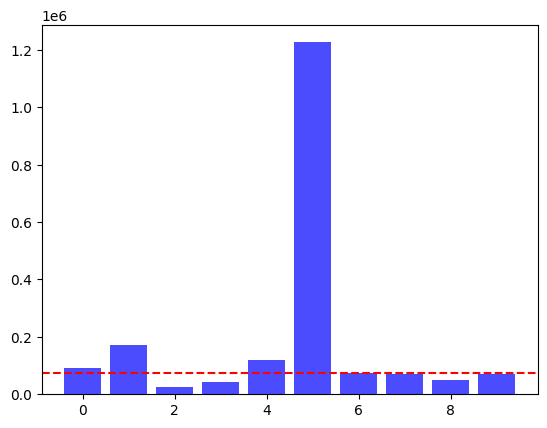

In [76]:
# Create a scatterplot to visually see how my model performed 

# Actual and predicted values
actual_valuations = [557000, 668300, 473000, 470100, 646800, 2256700, 499700, 465600, 452700, 526900]
predicted_values = [465000.0, 496666.67, 448566.67, 428800.0, 527500.0, 1030000.0, 425500.0, 394533.33, 403833.33, 455000.0]
differences = [92000.0, 171633.33, 24433.33, 41300.0, 119300.0, 1226700.0, 74200.0, 71066.67, 48866.67, 71900.0]

# Bar positions
positions = np.arange(len(actual_valuations))

# Create a bar plot
plt.bar(positions, differences, color='blue', alpha=0.7, label='Differences')

plt.axhline(y=average_error, color='red', linestyle='--', label=f'Average Error: {round(average_error, 2)}')


In [77]:
# Alternate way of calculating that I found

# Step 1: Create a list of actual valuations
actual_valuations = random_homes['totalActualVal'].tolist()

# Step 2: Calculate differences between predicted and actual values
differences = [actual - predicted for actual, predicted in zip(actual_valuations, predictions)]

# Step 3: Square each difference.
squared_differences = [difference ** 2 for difference in differences]


squared_differences

[563271111.1111102,
 8519290000.0,
 58984217777.777756,
 357210000.0,
 7270404444.4444475,
 34620804444.44443,
 1406250000.0,
 11158401111.111107,
 38027777.777778015,
 17361111.111111272]

## Ethics Review

Whenever we are modeling our data, it's critical that we take time to consider the impact our algorithms have on people's lives.

1. Describe one possible source of bias that exist might exist in this dataset and impact our estimated valuation?
2. What potential harm could arise due to how our knn regression algorithm works?  For example, what if *k* is too low or too high?  What impact can outliers have?  Would it make sense to normalize (e.g. standardize our values between 0 and 1) for our data points (sqft, age, basement) before calculating Euclidean Distance?
3. Should we have an appeal process for people that may be harmed by the results of our model?



#### Answer

Possible Source of Bias:
Bias can manifest in various ways, such as being influenced by specific regions or time periods, which could lead to a lack of representativeness for all results. One potential source of bias in the dataset could stem from socioeconomic factors. The estimated valuations may not accurately reflect the diversity in housing markets if the dataset predominantly includes homes from a specific income bracket or neighborhood. This bias could lead to underestimating or overestimating home values in areas with different socioeconomic characteristics.

Potential Harm and Algorithm Sensitivity:
The KNN regression algorithm's performance can be sensitive to the choice of k because it operates similarly to a collective decision-making process where the selection of 'k' plays a pivotal role. A low 'k' translates to too few people being asked, resulting in erratic predictions influenced by individual data points. Conversely, a high 'k' might oversmooth the model, causing it to overlook local patterns. Outliers, analogous to influential voices in this collective, can significantly skew predictions. While normalizing data, particularly standardizing features between 0 and 1, mitigates the algorithm's sensitivity to varying scales and enhances stability, it comes with inherent trade-offs. 

Appeal Process:
An appeal process, allowing individuals to challenge results, ensures fairness, considering factors not explicitly in the data. Combining these considerations paints a holistic picture of the ethical considerations and challenges in deploying automated models. Implementing an appeal process is essential. It ensures fairness and accountability, acknowledging the limitations of automated models in capturing the complexity of real-world situations. This process allows for human judgment, considering factors that may not be explicitly present in the data but are relevant to what is being modeled. 


